In [1]:
import sys, os
sys.path.append("/cluster/home/vogtva/pde-data-gen")

In [2]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [3]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from dotenv import load_dotenv
from pandas.plotting import parallel_coordinates
import importlib
import plotly.express as px
import os
import glob
import pandas as pd
import json

import src.db_tools as db_tools
from src.db_tools import (
    get_dataset,
    filter_df,
    filter_dataset,
    expand_json_column,
    make_animation,
    metrics_grid,
    plot_ball_behavior,
    plot_all_trajectories,
)
import src.classify as classify
from src.classify import classify_trajectories, compute_classification_metrics
importlib.reload(db_tools);
importlib.reload(classify);

In [8]:
model = "bruss"
run_id = "ball_big"
ds, output_dir = get_dataset("work", model, "ball_big")
df = ds.df

df = expand_json_column(df, "original_point", "op", True)
df = expand_json_column(df, "initial_condition", "ic", True)
df = classify_trajectories(df)
df["op"] = df["original_point"].astype(str)
df["ic"] = df["initial_condition"].astype(str)
df["du_dv"] = df["op_Du"].astype(str) + df["op_Dv"].astype(str)
df["ratio_b_a"] = df["B"] / df["A"]
df_filt = df[df.ic_type == "normal"]
df = df_filt

df.category = df.category.str.replace("DSS", "SS")

In [5]:
df = df.loc[6038:]

In [134]:
df.idx

6038    6038
6039    6039
6040    6040
6041    6041
6042    6042
        ... 
7195    7195
7196    7196
7197    7197
7198    7198
7199    7199
Name: idx, Length: 1162, dtype: int64

In [139]:
df.loc[6040]

run_id                                                        ball_big
model                                                            bruss
A                                                             0.914054
B                                                             2.796911
Du                                                            1.010033
Dv                                                            17.84868
Nx                                                                 128
dx                                                                 1.0
Nt                                                               60000
dt                                                              0.0025
n_snapshots                                                        100
output_file          /cluster/work/math/vogtva/bruss/ball_big/edb75...
random_seed                                                     646639
initial_condition    {"type": "hex_pattern", "amplitude": 0.25, "wa...
origin

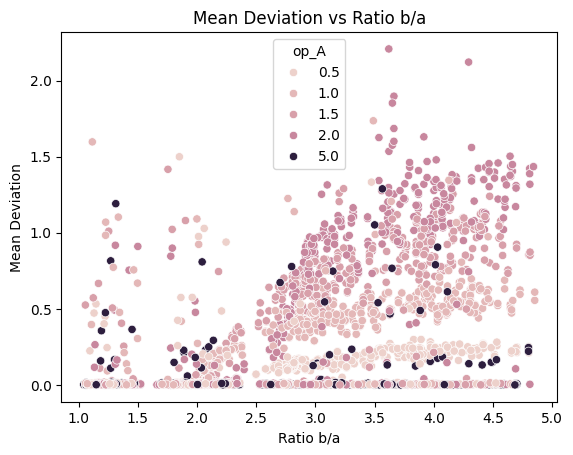

In [18]:
sns.scatterplot(data=df, x="ratio_b_a", y="dominant_power", hue="op_A")
plt.xlabel("Ratio b/a")
plt.ylabel("Mean Deviation")
plt.title("Mean Deviation vs Ratio b/a")
# plt.xscale('log')
# plt.yscale('log')
plt.show()

0.5


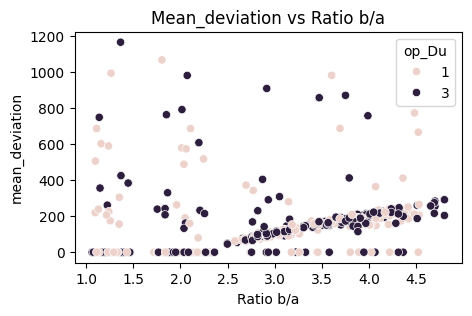

1.0


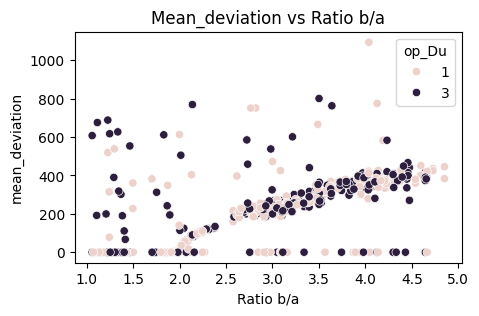

1.5


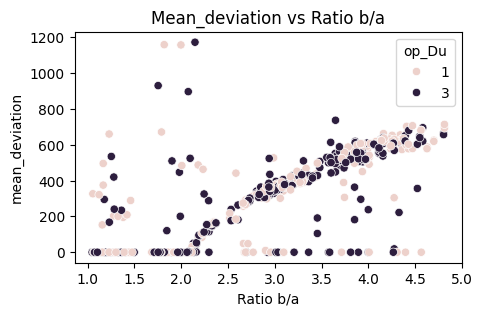

2.0


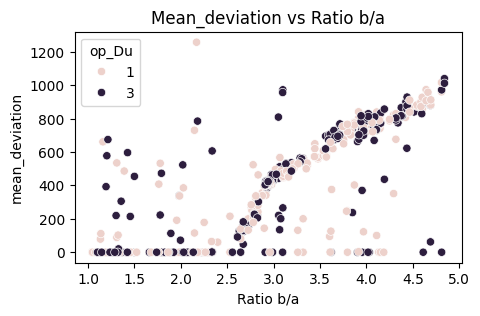

5.0


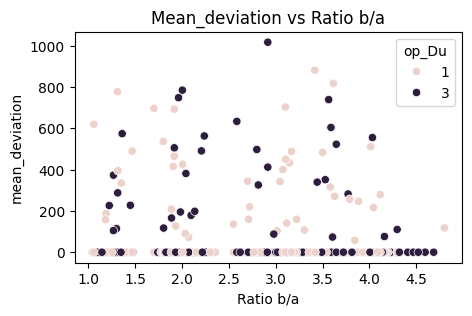

In [19]:
sns.set_palette("viridis")
metric = "mean_deviation"
for opA, df1 in df.groupby("op_A"):
    print(opA)
    plt.figure(figsize=(5, 3))
    sns.scatterplot(data=df1, x="ratio_b_a", y=metric, hue="op_Du")
    plt.xlabel("Ratio b/a")
    plt.title(f"{metric.capitalize()} vs Ratio b/a")
    # plt.xscale('log')
    # plt.yscale('log')
    plt.show()

In [20]:
df["category"].value_counts()

category
OSC    1492
SS     1372
DSS     550
INT     186
Name: count, dtype: int64

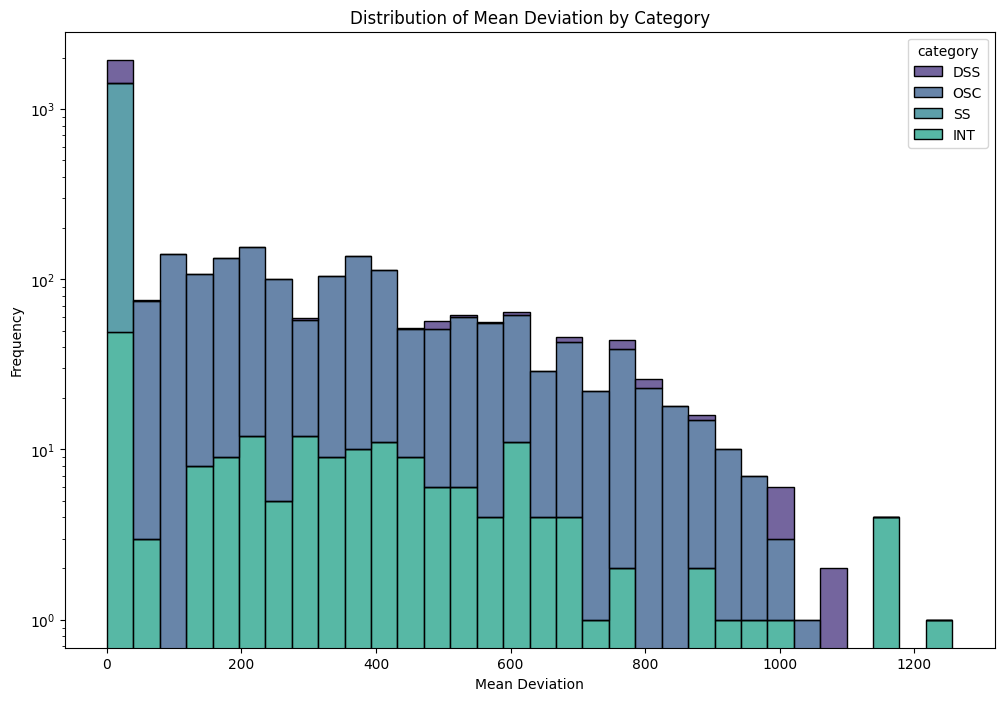

In [21]:
# Plot the distribution of mean_deviation' for each category
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=df, x="mean_deviation", hue="category", multiple="stack")
ax.set(yscale="log")
plt.xlabel("Mean Deviation")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Deviation by Category")
plt.show()

In [22]:
fig = px.scatter(
    df,
    x="A",
    y="B",
    color="category",
    title="Scatter plot of A vs B",
    labels={"A": "A", "B": "B"},
    width=800,
    height=800,
)

fig.show()


In [23]:
# filter out all ops where there is only one category
for op, df1 in df.groupby("op"):
    if len(df1.value_counts("category")) == 1 or df1.value_counts("category").min() < 4:
        df = df[df["op"] != op]

In [24]:
points_of_interest = []
for op, df1 in df.groupby("op"):
    print(op, df1.value_counts("category").to_dict())
    points_of_interest.append(json.loads(op.replace("'", '"')))
df_int = pd.DataFrame(points_of_interest)
df_int.to_csv("varied_points.csv")

{"A": 1.0, "B": 1.25, "Du": 1, "Dv": 4} {'SS': 22, 'DSS': 8}
{"A": 1.0, "B": 2.0, "Du": 1, "Dv": 11} {'OSC': 11, 'DSS': 10, 'INT': 5, 'SS': 4}
{"A": 1.0, "B": 2.0, "Du": 3, "Dv": 33} {'OSC': 12, 'INT': 7, 'DSS': 6, 'SS': 5}
{"A": 1.0, "B": 2.0, "Du": 3, "Dv": 54} {'OSC': 14, 'INT': 9, 'DSS': 7}
{"A": 1.5, "B": 3.0, "Du": 3, "Dv": 33} {'DSS': 12, 'INT': 6, 'OSC': 6, 'SS': 6}
{"A": 5.0, "B": 20.0, "Du": 1, "Dv": 11} {'DSS': 15, 'SS': 10, 'OSC': 5}
{"A": 5.0, "B": 6.25, "Du": 1, "Dv": 11} {'SS': 17, 'DSS': 13}


In [5]:
df["op"] = df["original_point"].astype(str)
for _, df1 in df.groupby("op"):
    original_point = df1.iloc[0]["original_point"]
    print(original_point, df1.value_counts("category").to_dict())
    plot_ball_behavior(filter_dataset(ds, df1), 70).show()
    break

{"A": 0.5, "B": 0.625, "Du": 1, "Dv": 11} {'SS': 24, 'INT': 3, 'OSC': 2, 'DSS': 1}


In [8]:
df_filt = df[df["op"] == '{"A": 5.0, "B": 6.25, "Du": 1, "Dv": 11}']
for ic, df1 in df_filt.groupby("category"):
    print(ic)
    plot_all_trajectories(filter_dataset(ds, df1), metric="dt")

DSS


SS


In [9]:
# Define the colorblind palette
colorblind_palette = sns.color_palette("colorblind")

# Define a fixed hue mapping
categories = ["SS", "INT", "OSC"]
hue_mapping = {cat: colorblind_palette[i] for i, cat in enumerate(categories)}

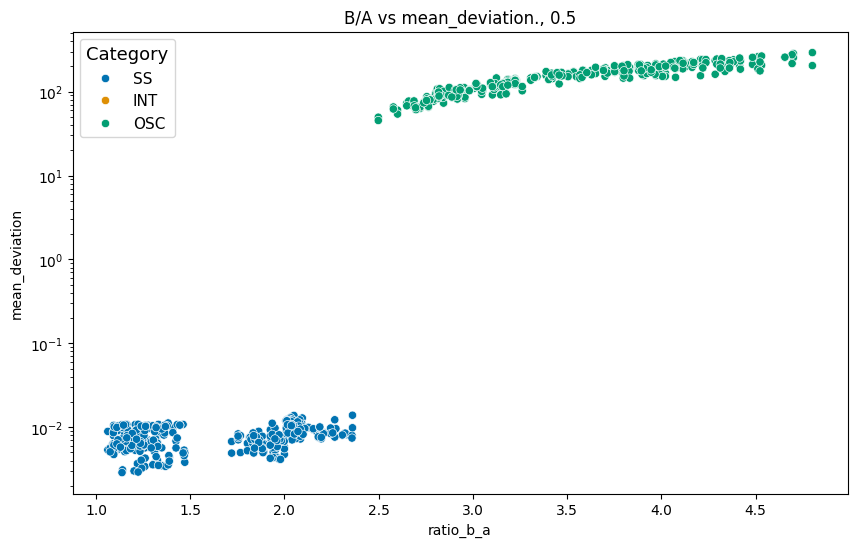

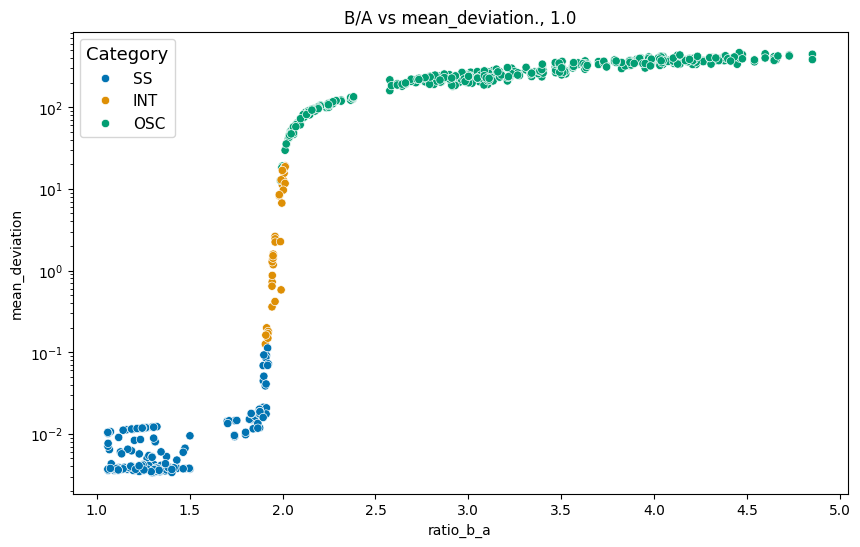

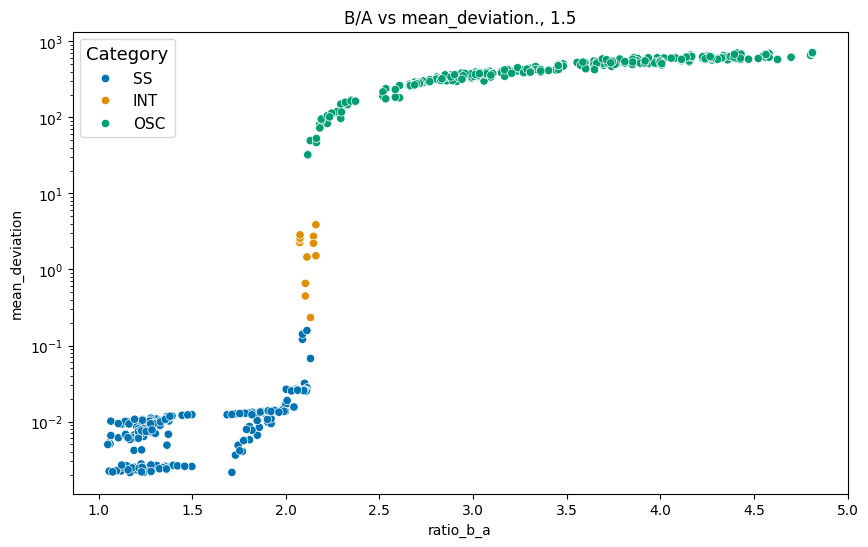

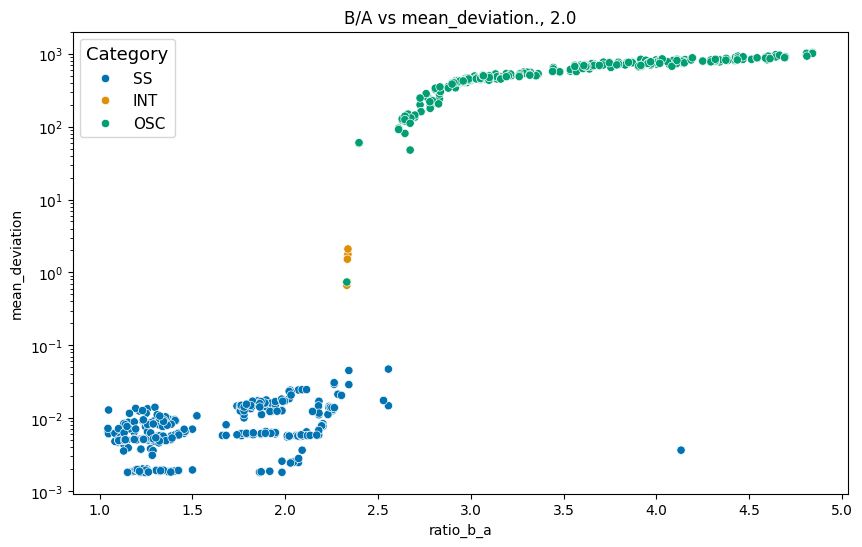

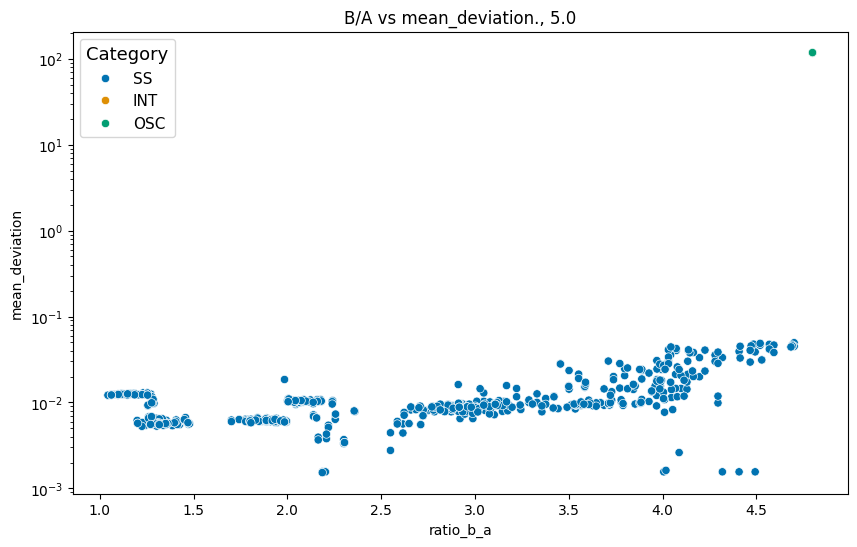

In [10]:
plt.style.use('seaborn-v0_8-colorblind')
for val, df1 in df.groupby("op_A"):
    plt.figure(figsize=(10, 6))
    metric = "mean_deviation"
    df1[metric] += 1e-3
    plt.yscale('log')
    ax = sns.scatterplot(df1, x="ratio_b_a", y=metric, hue="category", palette=hue_mapping, hue_order=categories)
    ax.legend(title="Category", title_fontsize='13', fontsize='11')
    plt.title(f"B/A vs {metric}., {val}")
    # plt.savefig(f"A0={val}_mean_dt.png")

In [115]:
df_sub = df[["output_file", "mean_deviation"]]

In [116]:
df_sub.to_csv("new.csv")